In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn.functional as F

In [3]:
words = open('names.txt').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [4]:
# let's only have one special token, and let's have it at index 0, offset others by 1
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
num_classes = len(stoi)

In [5]:
# Whole dataset

block_size = 3 # How many characters do we take to predict the next one : 3 chars to predict the 4th
X, Y, = [], [] # X, input | Y, labels

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append moving window

X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [6]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((3*2, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]


sum(p.nelement() for p in parameters) # total number of parameters

3481

In [7]:
# parameters learnable
for p in parameters:
    p.requires_grad = True

In [8]:
steps = 1000

In [9]:
# A good learning rate is between 0.0001 and 1.0
# One can try that and see how the loss goes up/down
# get lrs spaced exponentially in the interval
# we would like to search over these lrs
lre = torch.linspace(-3, 0, steps)
lrs = 10**lre

In [10]:
# use the lrs in the steps
# keep track of the losses
# and see how it gets better or worse

In [11]:
lri = []
lrei = []
lossi = []

for i in range(steps):
    # minibatches
    bs = 32
    ix = torch.randint(0, X.shape[0], (bs,))
    
    # forward pass
    emb = C[X[ix]] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, Y[ix]) # also Ys have to be at the same index
    # if (i+1)%100 == 0:
        # print(f"Iteration {i}: Minibatch loss : {loss.item()}")

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    lrei.append(lre[i])
    lossi.append(loss.item())

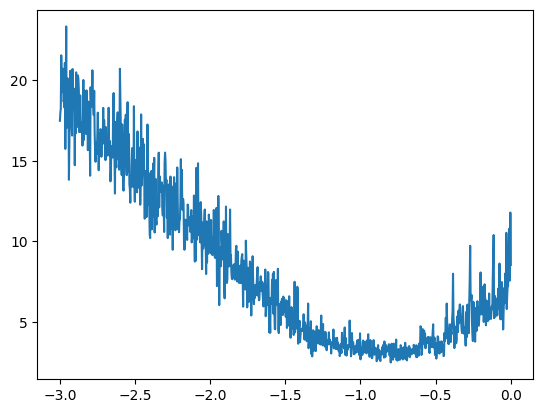

In [12]:
plt.plot(lrei, lossi)

In [13]:
# above we are plotting the exponent of the learning rate vs. loss
# you can see the stable point is around -1.0
# 10**-1.0 = 0.1, that was the pretty good stable lr

In [14]:
# now that we have a good learning rate we can use that to train properly